In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import mysql.connector
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Cargar las variables de entorno del archivo .env

In [2]:
load_dotenv()
db_host = os.getenv('DB_HOST')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_name = os.getenv('DB_NAME')

# Conectar a la base de datos MySQL

In [3]:
conn = mysql.connector.connect(
    host=db_host,
    user=db_user,
    password=db_password,
    database=db_name
)

# Ejecutar la consulta SQL

In [4]:
query = """
SELECT sku, user_id, created_at, total_orden 
FROM order_main where 
    created_at >= DATE_SUB(CURDATE(), INTERVAL 1 YEAR)
    AND created_at < DATE_FORMAT(CURDATE(), '%Y-%m-01');
"""

df = pd.read_sql(query, conn)

conn.close()

### Cargar los datos y realizar las transformaciones necesarias

In [5]:
df.columns = ['SKU', 'USUARIO', 'FECHA', 'VENTA']
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d', errors='coerce')
df['PERIODO'] = df['FECHA'].dt.strftime('%Y-%m')
df.head()

,SKU,USUARIO,FECHA,VENTA,PERIODO
0,VRT-02122023081205,13579.0,2023-12-02 08:41:05,40.84,2023-12
1,VRT-02122023101251,52071.0,2023-12-02 10:18:51,54.82,2023-12
2,VRT-02122023011249,52058.0,2023-12-02 13:42:49,15.98,2023-12
3,VRT-02122023061243,3057.0,2023-12-02 18:06:43,25.96,2023-12
4,VRT-02122023101226,29980.0,2023-12-02 22:23:26,1.56,2023-12


In [6]:
df.to_csv('data_cohort.csv', index=True)

# Calcular la cohorte del primer pedido


In [7]:
df['COHORTGROUPO'] = df.groupby('USUARIO')['FECHA'].transform('min').dt.strftime('%Y-%m')
df.head()

,SKU,USUARIO,FECHA,VENTA,PERIODO,COHORTGROUPO
0,VRT-02122023081205,13579.0,2023-12-02 08:41:05,40.84,2023-12,2023-12
1,VRT-02122023101251,52071.0,2023-12-02 10:18:51,54.82,2023-12,2023-12
2,VRT-02122023011249,52058.0,2023-12-02 13:42:49,15.98,2023-12,2023-12
3,VRT-02122023061243,3057.0,2023-12-02 18:06:43,25.96,2023-12,2023-12
4,VRT-02122023101226,29980.0,2023-12-02 22:23:26,1.56,2023-12,2023-12


### Agrupar por cohortes y períodos

In [8]:
grouped = df.groupby(['COHORTGROUPO', 'PERIODO']).agg({'USUARIO': pd.Series.nunique,
                                                      'SKU': pd.Series.nunique,
                                                      'VENTA': np.sum})
grouped.head()

USUARIO  SKU    VENTA
COHORTGROUPO PERIODO                       
2023-12      2023-12      364  511  9572.93
             2024-01       54  107  1903.26
             2024-02       29   98  1791.15
             2024-03       27   38   597.78
             2024-04       21   56  1423.46

### Calcular tamaño del grupo de cohortes

In [9]:
cohort_group_size = grouped['USUARIO'].groupby(level=0).first()
cohort_group_size.head()

COHORTGROUPO
2023-12    364
2024-01    156
2024-02     88
2024-03    100
2024-04     82
Name: USUARIO, dtype: int64

### Crear matriz de retención en enteros y en porcentaje


In [10]:
retencion_int = grouped['USUARIO'].unstack(0)  # Datos de retención en enteros
retencion_int.head()

COHORTGROUPO,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
PERIODO,,,,,,,,,,,,
2023-12,364.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01,54.0,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02,29.0,12.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03,27.0,11.0,5.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04,21.0,9.0,4.0,6.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
retencion_percent = retencion_int.divide(cohort_group_size, axis=1)  # Datos de retención en porcentaje
retencion_percent.head()

COHORTGROUPO,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
PERIODO,,,,,,,,,,,,
2023-12,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01,0.148352,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02,0.079670,0.076923,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03,0.074176,0.070513,0.056818,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04,0.057692,0.057692,0.045455,0.06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Reemplazar los ceros iniciales con NaN

In [12]:
mask = retencion_int.applymap(lambda x: np.nan if x == 0 else x)

# Crear matriz de gasto por cohorte

In [13]:
spending_cohort = grouped['VENTA'].unstack(0)  # Gasto total por cohorte
spending_cohort.head()

COHORTGROUPO,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
PERIODO,,,,,,,,,,,,
2023-12,9572.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01,1903.26,3652.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02,1791.15,477.95,3765.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03,597.78,289.13,172.90,5124.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04,1423.46,192.94,1358.26,435.38,2687.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN



### Exportar datos a CSV

In [14]:
retencion_int_t = retencion_int.T
retencion_percent_t = retencion_percent.T
spending_cohort_t = spending_cohort.T

mes_actual = (datetime.now() - relativedelta(months=1)).strftime('%B')

# Guarda los archivos CSV agregando el mes actual al final del nombre
retencion_int_t.to_csv(f'datareten_int_{mes_actual}.csv', index=True)
retencion_percent_t.to_csv(f'datareten_percent_{mes_actual}.csv', index=True)

### Configurar tamaño de figura y crear el primer gráfico (porcentaje)


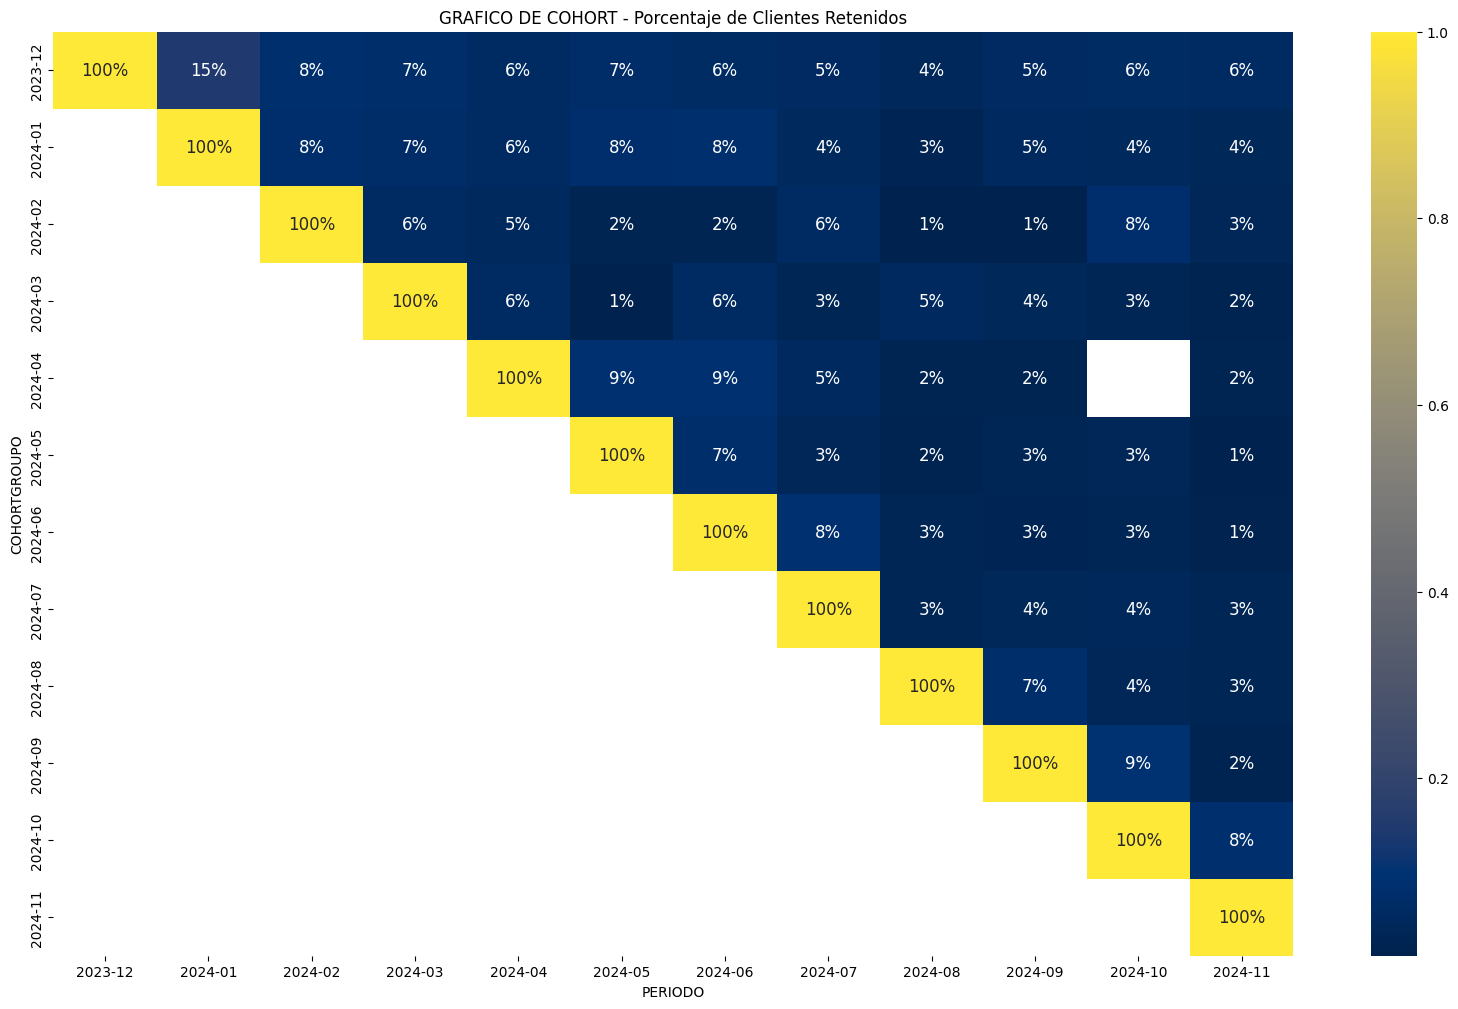

In [15]:
plt.figure(figsize=(20, 12))
plt.title('GRAFICO DE COHORT - Porcentaje de Clientes Retenidos')
sns.heatmap(data=retencion_percent.T,
            annot=True,
            fmt=".0%",  # Formato de porcentaje sin decimales
            annot_kws={'size': 12},  # Tamaño de las anotaciones
            cbar=True,
            cmap='cividis')
plt.savefig(f'datareten_percent_{mes_actual}.png')
plt.show()

In [16]:
# Crear el segundo gráfico (cantidad)

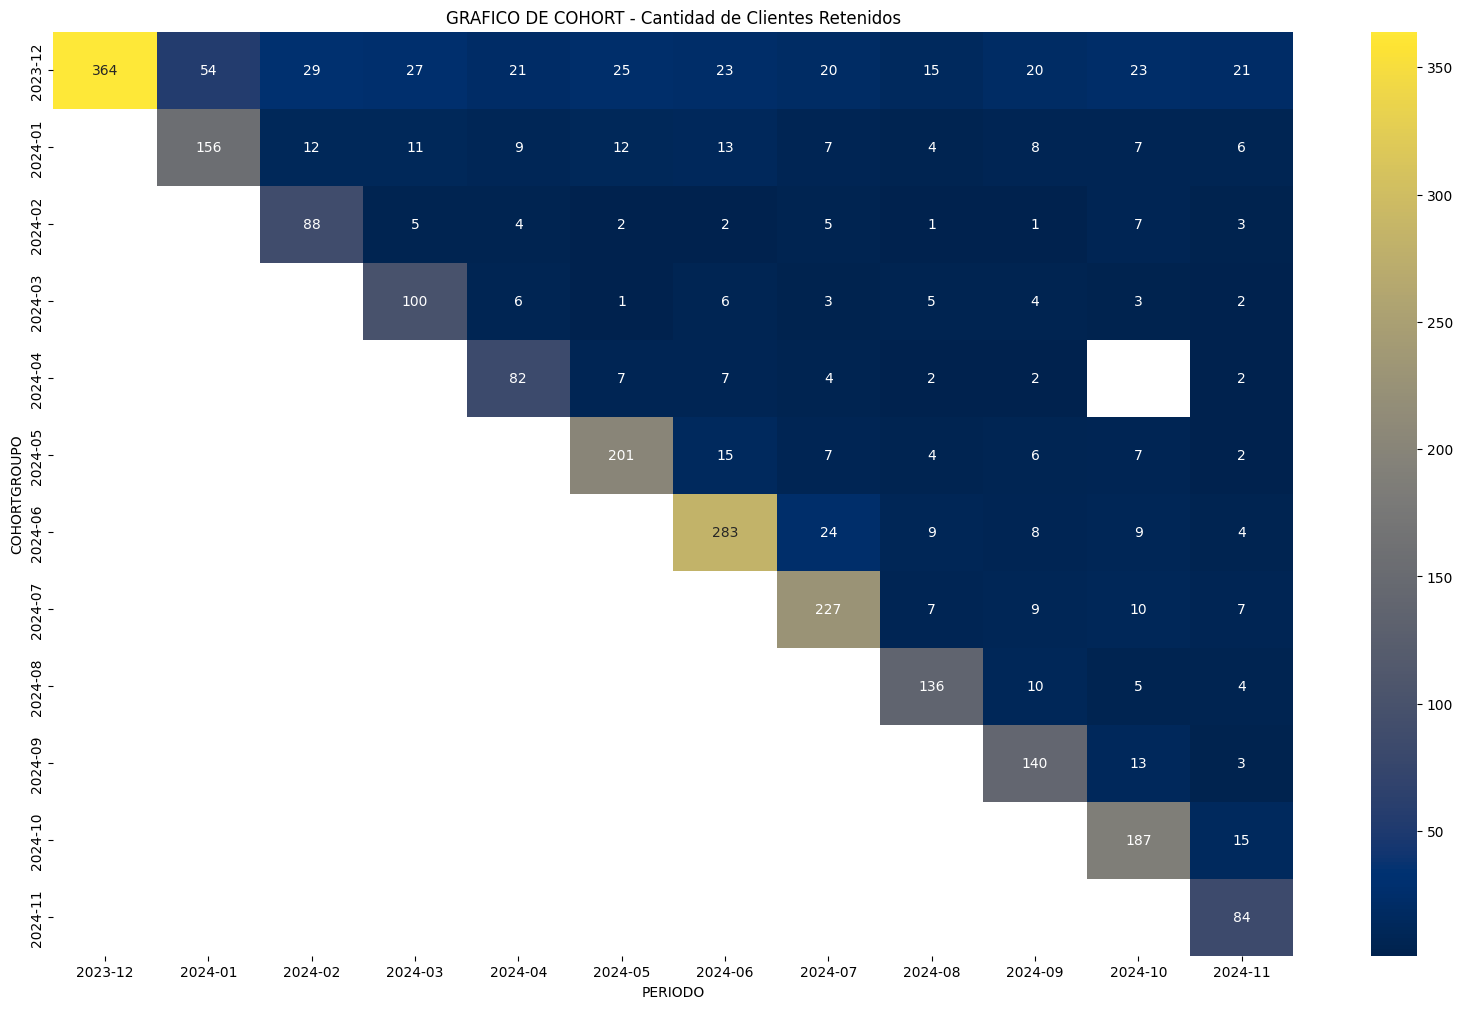

In [17]:
plt.figure(figsize=(20, 12))
plt.title('GRAFICO DE COHORT - Cantidad de Clientes Retenidos')
sns.heatmap(data=mask.T,  # Asegurar enteros
            annot=True,
            fmt=".0f",  # Formato de números flotantes sin decimales
            annot_kws={'size': 10},  # Tamaño de las anotaciones
            cbar=True,
            cmap='cividis')
plt.savefig(f'datareten_int_{mes_actual}.png')
plt.show()


In [18]:
# Crear el tercer gráfico (gasto por cohorte)

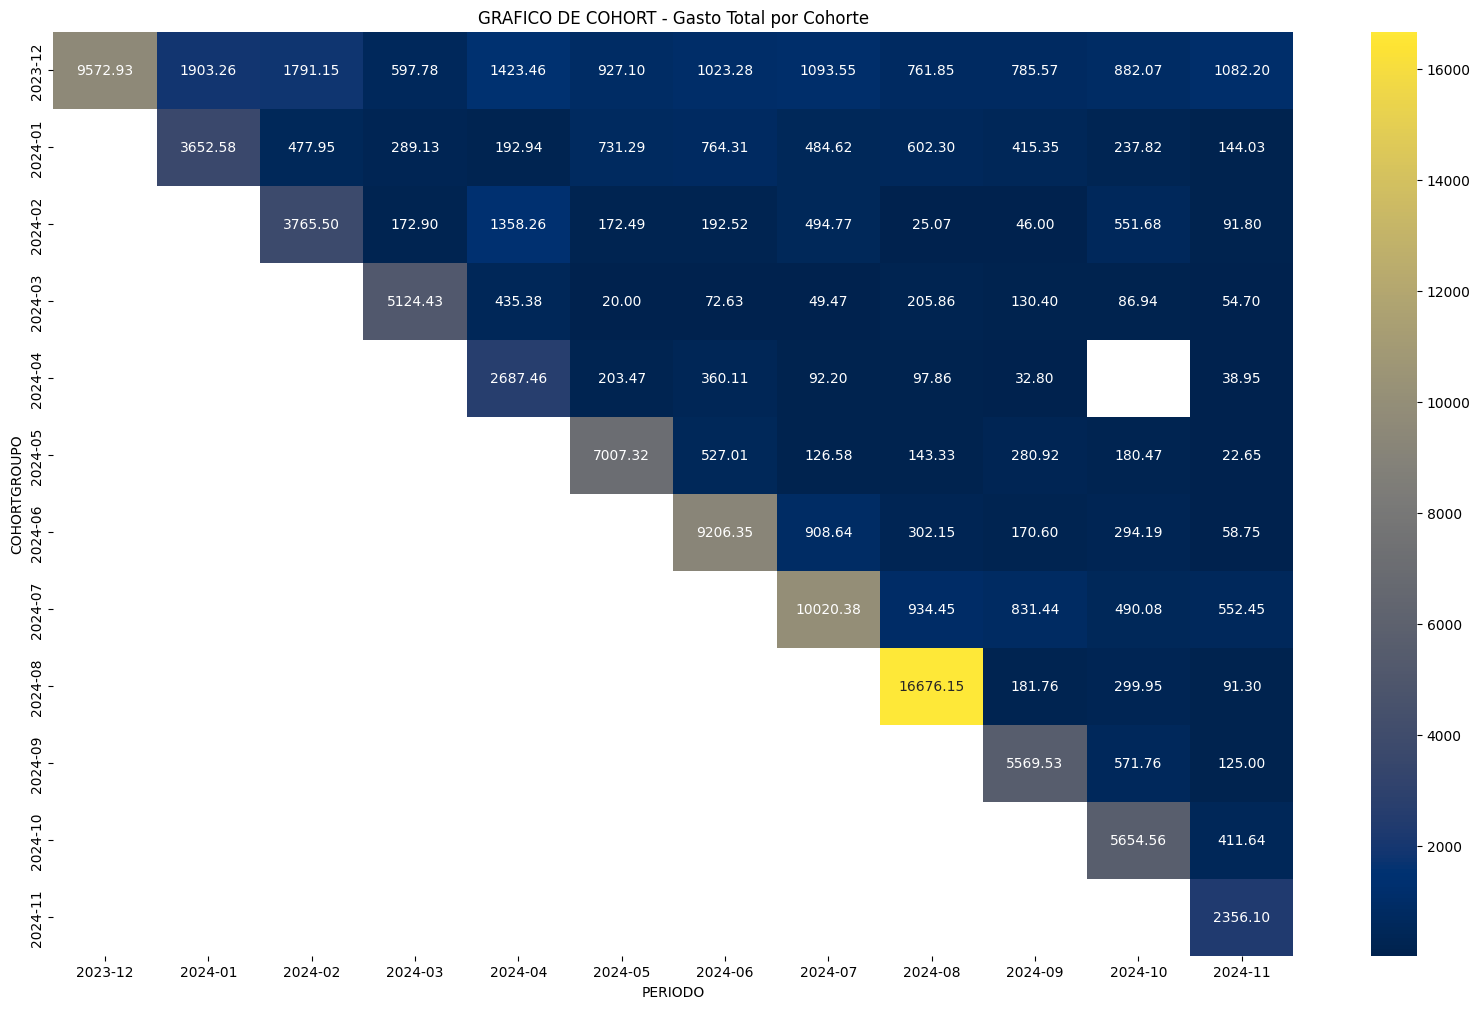

In [19]:
plt.figure(figsize=(20, 12))
plt.title('GRAFICO DE COHORT - Gasto Total por Cohorte')
sns.heatmap(data=spending_cohort.T,  # Asegurar enteros
            annot=True,
            fmt=".2f",  # Formato de números flotantes con dos decimales
            annot_kws={'size': 10},  # Tamaño de las anotaciones
            cbar=True,
            cmap='cividis')
plt.show()